In [7]:
import numpy as np
import mindspore.numpy as mnp

from mindspore import Tensor
from mindspore import load_checkpoint, load_param_into_net
from mindspore import context

import os
import matplotlib.pyplot as plt
%matplotlib inline


In [8]:
# 预处理 可视化 所用的数据
dpath = "data/"

local_filename = os.path.join(
    dpath, 'alanine-dipeptide-3x250ns-heavy-atom-distances.npz')
with np.load(local_filename) as fh:
    feat_array = [fh[key] for key in fh.keys()]

feat_array = np.concatenate(feat_array, 0)
feat_array = np.log(feat_array+1e-5)  # transform to log-scale

feat_mean = np.mean(feat_array, 0, keepdims=True)
feat_std = np.std(feat_array, 0, keepdims=True)
feat_array = (feat_array-feat_mean)/feat_std  # Whitening input features

local_filename = os.path.join(
    dpath, 'alanine-dipeptide-3x250ns-backbone-dihedrals.npz')
with np.load(local_filename) as fh:
    torsion_array = [fh[key] for key in fh.keys()]
torsion_array = np.concatenate(torsion_array, 0)


show_data_ids = np.loadtxt(os.path.join(
    dpath, "selected_data_ids.txt")).astype(np.int32)[:500]
feat_data = feat_array[show_data_ids]
torsion_data = torsion_array[show_data_ids]

print(feat_data.shape)
print(torsion_data.shape)


(500, 45)
(500, 2)


In [9]:
from codes.model import WithLossCell
context.set_context(mode=context.GRAPH_MODE)  # Inference

num_class = 8
latent_dim = 4

input_dim = 45
hidden_dim = 128
idm_model = WithLossCell(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim,
                         num_class=num_class, temperature=1e-1, reg_recon=1e-1)
idm_model.set_train(False)


WithLossCell<
  (act_fn): Tanh<>
  (decoder): SequentialCell<
    (0): Dense<input_channels=4, output_channels=128, has_bias=True>
    (1): Tanh<>
    (2): BatchNorm1d<num_features=128, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=2.gamma, shape=(128,), dtype=Float32, requires_grad=True), beta=Parameter (name=2.beta, shape=(128,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=2.moving_mean, shape=(128,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=2.moving_variance, shape=(128,), dtype=Float32, requires_grad=False)>
    (3): Dense<input_channels=128, output_channels=128, has_bias=True>
    (4): Tanh<>
    (5): BatchNorm1d<num_features=128, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=5.gamma, shape=(128,), dtype=Float32, requires_grad=True), beta=Parameter (name=5.beta, shape=(128,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=5.moving_mean, shape=(128,), dtype=Float32, requires_grad=Fals

In [10]:
# resolutions: [4,50,200,400]
param_dict = load_checkpoint(
    "./ckpts/" + "model_epoch_5000.ckpt")
load_param_into_net(idm_model, param_dict)


[]

In [11]:
feat_data = Tensor(feat_data, mnp.float32)

cluster = idm_model.inference(feat_data)
result = cluster.asnumpy()
print(result.shape)


(500, 8)


In [12]:
class_set = np.unique(np.argmax(result, axis=-1))
# print(len(class_set))

color_idx = np.argmax(result, axis=-1)
for i, item in enumerate(class_set):
    id = color_idx == item
    color_idx[id] = i


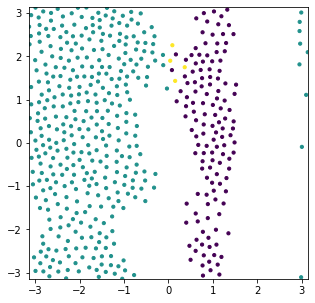

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(x=torsion_data[:, 0], y=torsion_data[:, 1], c=color_idx, s=10)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()
